<a href="https://colab.research.google.com/github/rudysemola/IFTS-MELA-ml-lab/blob/main/timeseries_classification_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeseries classification: Classificazione delle serie temporali usando CNN e RNN (parte 2)

**Cosa Impareremo:** 
- Risolvere un tipico problema di classificazione delle serie temporali per casi d'uso industriali.
- Caricare, visualizzare e standardizzare dati strutturati (serie temporali)
- Costruire, addestrare e valutare modelli di CNN e RNN
- Analizzare la curva di apprendimento

## Introduzione

Questo Lab è un'introduzione alla previsione di serie temporali utilizzando Keras-TensorFlow.

Siamo interessati ad addestrare da zero un classificatore di serie temporali sul set di dati FordA  per un caso d'uso industriale.

In [ ]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

## Load del Dataset FordA

Il set di dati che stiamo usando qui si chiama FordA ([dettagli](http://www.j-wichard.de/publications/FordPaper.pdf)).
Contiene 3601 istanze di training e altre 1320 istanze di test. 
Ogni serie temporale corrisponde a una misurazione del rumore del motore catturata da un sensore. 

Problema: classificazione binaria.
Lo scenario considerato è di un industria automobilistica che vuole effettuare dei test con obiettivo rilevare automaticamente la presenza di un problema specifico con il motore.

Useremo `FordA_TRAIN` file per training e 
`FordA_TEST` file per testing. 

In [ ]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

Vediamo che cosa abbiamo sotto mano 

In [ ]:
print(x_train.shape, y_train.shape, np.min(y_train), np.max(y_train))
print(x_test.shape, y_test.shape, np.min(x_test), np.max(y_test))

Ai fini del laboratorio, riduciamo la dimenzione sia del tr che del test

In [ ]:
x_train, y_train = x_train[0:1800], y_train[0:1800]
x_test, y_test = x_test[0:1000], y_test[0:1000]

In [ ]:
print(x_train.shape, y_train.shape, np.min(y_train), np.max(y_train))
print(x_test.shape, y_test.shape, np.min(x_test), np.max(y_test))

## Visualizziamo i dati

Qui visualizziamo un esempio di serie temporali per ogni classe nel set di dati

Il modo migliore per visualizzare questi dati è l'uso di grafici (plot).

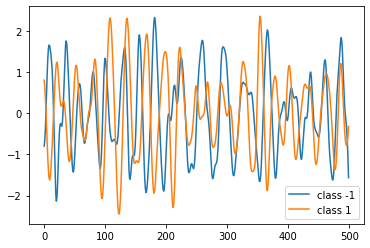

In [ ]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

## Standardizzare (normalizzare) i dati

Le nostre serie temporali sono già in un'unica lunghezza (500). 
Tuttavia, i loro valori sono di solito in vari intervalli. Questo non è l'ideale per una rete neurale; in generale dovremmo cercare di normalizzare i valori di input.

Per questo specifico set di dati, i dati sono già z-normalizzati: ogni campione di serie temporali ha una media uguale a zero e una deviazione standard uguale a uno. *Questo tipo di normalizzazione è molto comune per i problemi di classificazione delle serie temporali.*

Si noti che i dati delle serie temporali utilizzati qui sono univariati, il che significa che abbiamo un solo canale per esempio di serie temporali. Trasformeremo quindi la serie temporale in una multivariata ad un canale utilizzando un semplice rimodellamento tramite numpy. Questo ci permetterà di costruire un modello facilmente applicabile al tempo multivariato serie.

In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

Per usare `sparse_categorical_crossentropy`, dovremo contare il numero delle classi in anticipo.

In [ ]:
num_classes = len(np.unique(y_train)) # 
num_classes

2

Ora mescoliamo il dataset perché useremo l'opzione `validation_split`durante l'allenamento.

In [ ]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

Normalizza le etichette su numeri interi positivi. Le etichette previste saranno quindi 0 e 1.


In [ ]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Costruiamo il modello RNN

Una Rete Neurale Ricorrente (RNN) è un tipo di rete neurale adatta ai dati di serie temporali. 
Elaborano una serie temporale passo dopo passo, mantenendo uno stato interno da un passo temporale all'altro.

In questo tutorial utilizzerai un RNN layer chiamato Simple RNN (`keras.layers.SimpleRNN`).


Un importante argomento del costruttore per tutti i livelli RNN Keras come `keras.layers.SimpleRNN`, è l'argomento `return_sequences`. 
Questa impostazione può configurare il livello in uno dei due modi seguenti:

1. Se `False`, l'impostazione predefinita, il livello restituisce solo l'output del passaggio temporale finale, dando al modello il tempo di riscaldare il suo stato interno prima di effettuare una singola previsione:


![An LSTM warming up and making a single prediction](https://www.tensorflow.org/tutorials/structured_data/images/lstm_1_window.png)

2. Se `True`, il livello restituisce un output per ogni input. Questo è utile per: *Impilare i livelli RNN*. Addestrare un modello su più fasi temporali contemporaneamente.

![An LSTM making a prediction after every time step](https://www.tensorflow.org/tutorials/structured_data/images/lstm_many_window.png)

**(Q&A)**  Quale ci sinteressa?

In [ ]:
input_shape = None, x_train.shape[1:][0], x_train.shape[1:][1]
input_shape

In [ ]:
model = keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units],
    keras.layers.SimpleRNN(32, return_sequences=False),
    # Shape => [batch, time, features]
    keras.layers.Dense(num_classes, activation="softmax")
])

model.build(input_shape=input_shape)

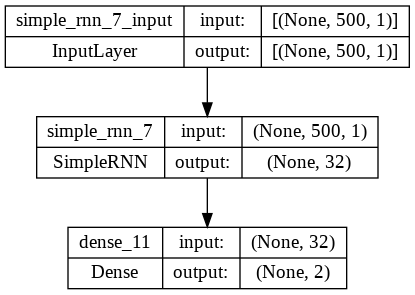

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

## Addestriamo il modello

In [ ]:
epochs = 75
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

In [ ]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

In [ ]:
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.25,
    verbose=1,
)

## Valutiamo il modello sui dati di test

In [ ]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

## Plot della curva di apprendimento 

Analizziamo la learning curve ottenuta

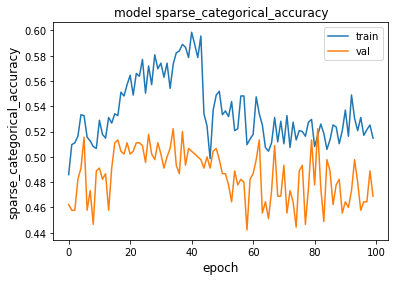

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

**Cosa possiamo osservare?**

Possiamo vedere come l'accuratezza nel train raggiunga (?) dopo (?) epoche. 
Tuttavia, osservando l'accuratezza nel validation, possiamo vedere come la rete (?) 

Oltre la (?)esima epoca, se continuiamo con l'allenamento, l'accuratezza nel  validation  comincerà a diminuire mentre l'accuratezza nel train continuerà ad aumentare: il modello inizia a "overfittare".

(?) Studio ed osservazioni degli studenti


# Esercizi (suggeriti)

- Sperimentare con lo stesso setup presentato la model selection
- Cercare di migliorare le performance (tradeoff con il tempo concesso)
- Provare a verificare il fenomeno dell'overfitting


## RNNs 

Keras documentazione [RNNs](https://keras.io/api/layers/recurrent_layers/)

**Esercizio** 

Sperimentare con LSTM e GRU. Performance ottenute 

In [ ]:
#TODO

# Your Turn!

1. Provare con intero dataset FordA questo lab!
Quanto tempo impiega? Che risultati sei riuscito ad ottenere?

2. Tutorial Tensorflow Previsione di serie temporali: https://www.tensorflow.org/tutorials/structured_data/time_series